### Import Necessary Module and Set Path 

In [8]:
import sqlite3 as lite
import os
import sys
import numpy as np
from pyne import nucname
import collections
import matplotlib.pyplot as plt
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()

In [9]:
import analysis as an

## Run Cyclus Input file

In [4]:
! rm astrid.sqlite
! cyclus -o astrid.sqlite astrid.xml

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

### The output file should be named 
         
          astrid.sqlite

In [10]:
# get sqlite cursor and simulation time parameters
filename = 'cyclus.sqlite'
cur = an.get_cursor(filename)
init_year, init_month, duration, timestep = an.get_timesteps(cur)

In [11]:
# get where_fuel
# Wait for the complete message to move on
agent_ids = an.get_prototype_id(cur, 'uox_mixer')
fuel_from_uox = an.facility_commodity_flux(cur, agent_ids, ['mox'], True, False)
agent_ids = an.get_prototype_id(cur, 'mox_mixer')
fuel_from_mox = an.facility_commodity_flux(cur, agent_ids, ['mox'], True, False)
dict = {}
dict['fuel from spent uox'] = fuel_from_uox['mox']
dict['fuel from spent mox'] = fuel_from_mox['mox']
an.stacked_bar_chart(dict, timestep,
                  'Years', 'Mass[MTHM]',
                  'MOX Fuel Loading vs Time',
                  'where_fuel_sep',
                  init_year)

/home/dkadkf/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


In [12]:
# cum plutonium flux
agent_ids = an.get_agent_ids(cur, 'separations')
pu = an.facility_commodity_flux(cur, agent_ids, ['uox_Pu', 'mox_Pu'], True, False)
pu['pu from legacy'] = pu.pop('uox_Pu')
pu['pu from spent sfr fuel'] = pu.pop('mox_Pu')
an.stacked_bar_chart(pu, timestep, 'Years', 'Mass [MTHM]', 'Total Pu Mass vs Time', 'pu', init_year)

/home/dkadkf/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


In [13]:
# get reprocessing waste
agent_ids = an.get_agent_ids(cur, 'separations')
reprocess_waste = an.facility_commodity_flux(cur, agent_ids, ['uox_reprocess_waste', 'mox_reprocess_waste'], True, False)
an.stacked_bar_chart(reprocess_waste, timestep, 'Years', 'Mass [MTHM]',
                     'Reprocess Waste vs Time', 'reprocess_waste', init_year)

/home/dkadkf/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


In [15]:
an.plot_power(cur)


# get fuel source and inventory
fuel = an.fuel_usage_timeseries(cur, ['mox'], True)

# tails flux
tailings = collections.OrderedDict()
agent_ids = an.get_agent_ids(cur, 'separations')
pu = an.facility_commodity_flux(cur, agent_ids, ['uox_Pu', 'mox_Pu'], True, True)
pu['pu from legacy'] = pu.pop('uox_Pu')
pu['pu from spent sfr fuel'] = pu.pop('mox_Pu')
tailings['tailings used'] = [i * .91 for i in fuel['mox']]

# cum plutonium flux
agent_ids = an.get_agent_ids(cur, 'separations')
pu = an.facility_commodity_flux(cur, agent_ids, ['uox_Pu', 'mox_Pu'], True, True)
pu['pu from legacy'] = pu.pop('uox_Pu')
pu['pu from spent sfr fuel'] = pu.pop('mox_Pu')


# get total legacy snf reprocessed:
#Pu in spent uox
x = cur.execute('SELECT sum(massfrac) FROM recipes LEFT OUTER JOIN compositions ON '
                'compositions.qualid = recipes.qualid '
                'WHERE recipe = "uox_used_fuel_recipe" '
                'and (nucid > 940000000 and nucid < 950000000)').fetchone()
y = cur.execute('SELECT sum(massfrac) FROM recipes LEFT OUTER JOIN compositions ON '
                'compositions.qualid = recipes.qualid '
                'WHERE recipe = "sfr_spent_mox_recipe" '
                'and (nucid > 940000000 and nucid < 950000000)').fetchone()
# print('Total Legacy SNF reprocessed: ')
# print(max(i / x[0] for i in pu['pu from legacy']))
dictionary = {}
rep_throughput_legacy = [i / x[0] for i in pu['pu from legacy']]
rep_throughput_mox = [i / y[0] for i in pu['pu from spent sfr fuel']]
dictionary['reprocessing throughput'] = [x + y for x, y in zip(rep_throughput_legacy, rep_throughput_mox)]

# get reprocessing waste
agent_ids = an.get_agent_ids(cur, 'separations')
reprocess_waste = an.facility_commodity_flux(cur, agent_ids, ['uox_reprocess_waste', 'mox_reprocess_waste'], True, True)


# get rep U inventorypu['pu from legacy'])/x[0]
rep_U = an.get_trade_dict(cur, 'separations', 'storage', False, False)
print('Total Reprocessed Uranium Stockpile: ')
print(max(rep_U['separ to stora']))

# get Pu isotopics
trade_dict = an.get_trade_dict(cur, 'separations', 'mixer', False, False)
print('Total Reprocess Waste: ')
print(max(trade_dict['separ to mixer']))
trade_dict = an.get_trade_dict(cur, 'separations', 'mixer', False, True)

agent_ids = an.get_prototype_id(cur, 'uox_mixer')
fuel_from_uox = an.facility_commodity_flux(cur, agent_ids, ['mox'], True, False)
agent_ids = an.get_prototype_id(cur, 'mox_mixer')
fuel_from_mox = an.facility_commodity_flux(cur, agent_ids, ['mox'], True, False)
dict = {}
dict['fuel from spent uox'] = fuel_from_uox['mox']
dict['fuel from spent mox'] = fuel_from_mox['mox']


print('Total MOX used in MTHM:')
print(max(fuel['mox']))
print('Total MOX from legacy UOX Waste in MTHM:')
print(sum(dict['fuel from spent uox']))
print('Total Pu from legacy UNF:')
print(max(pu['pu from legacy']))
print('Total legacy UNF reprocessed in MTHM:')
print(sum(dict['fuel from spent uox'])*.22/x[0])
print('Total MOX from MOX Waste in MTHM:')
print(sum(dict['fuel from spent mox']))
print('Total Tailings used in MTHM:')
print(max(tailings['tailings used']))
print('Total Pu reprocessed in MTHM:')
print(max([x+y for x, y in zip(pu['pu from legacy'], pu['pu from spent sfr fuel'])]))

print('Finished!')

Sink_Source_Inst has no values


/home/dkadkf/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


Sink_Source_Inst has no values
Total Reprocessed Uranium Stockpile: 
182473.880105
Total Reprocess Waste: 
17610.9446076
Total MOX used in MTHM:
63820.416
Total MOX from legacy UOX Waste in MTHM:
3056.832
Total Pu from legacy UNF:
1351.52735956
Total legacy UNF reprocessed in MTHM:
71726.2971111
Total MOX from MOX Waste in MTHM:
60763.584
Total Tailings used in MTHM:
58076.57856
Total Pu reprocessed in MTHM:
17610.9446076
Finished!


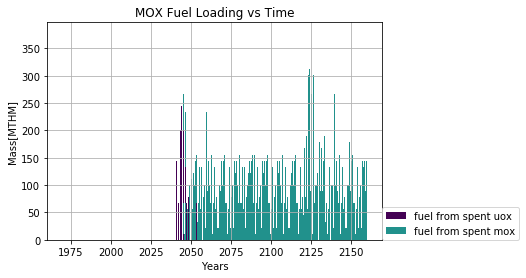

In [19]:
# Display fuel loading with origin
from IPython.display import Image
Image(filename='where_fuel_sep.png')

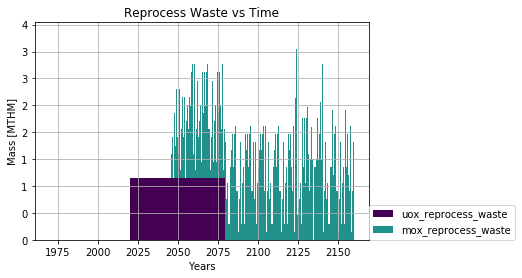

In [20]:
# Display Reprocess Waste
from IPython.display import Image
Image(filename='reprocess_waste.png')

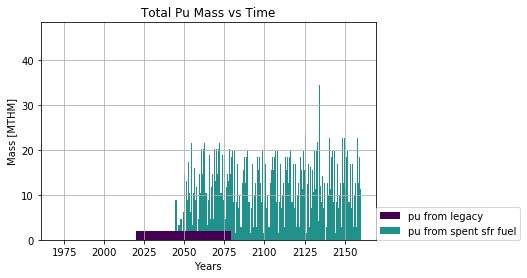

In [21]:
# Display plutonium
from IPython.display import Image
Image(filename='pu.png')